# D3D IO Module

The following example will familiarize the user with using the D3D toolbox in MHKiT-Python. `D3D` can be used to plot the data from a NetCDF output from Delft3D. The example will walk through a flume case with a turbine in it. [SNL-D3D-CEC-FM](https://github.com/MHKiT-Software/MHKiT-Python) The flume is 18 m long and 4 m wide with the turbine placed at 6 m along the length and 3 m along the width. The turbine used for this simulation has a circular cross-section with a diameter of 0.7m, a thrust coefficient of 0.72, and a power coefficient of 0.45. The simulation was run with 5 depth layers and 3-time intervals.

This example will show how to create a line plot at a desired depth for different variables outputs of Delft3D using matplotlib. It will also show how to make a contour plot of a given plane or depth for the variable output by Delft3D or how to use those variables to calculate turbulence intensity. This module can be helpful to visualize the wake of a turbine and help predict how a turbine will affect the surrounding area. 

Start by importing the necessary python packages and MHKiT module.  


In [1]:
from os.path import abspath, dirname, join, normpath, relpath
from mhkit.river.io import d3d 
import scipy.interpolate as interp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import netCDF4

## Loading data from Delft3d as a netCDF 

 A NetCDF file has been saved in the [\\MHKiT-Python\\examples\\data\\river\\d3d](https://github.com/browniea/MHKiT-Python/tree/d3d/examples/data/river/d3d) directory of a simple flume case with a turbine as an example. Here we are inputting a file path `datadir` and a file name `filename` as strings so the NetCDF file can be saved under `data` as a NetCDF object.  
 
 
There are many variables saved in the NetCDF object, here we look at all the different variables we can plot.
 

In [2]:
datadir = normpath(join(relpath(join('data', 'river', 'd3d'))))
filename= 'turbineTest_map.nc'
data = netCDF4.Dataset(join(datadir,filename))

data.variables.keys()

dict_keys(['mesh2d_enc_x', 'mesh2d_enc_y', 'mesh2d_enc_node_count', 'mesh2d_enc_part_node_count', 'mesh2d_enc_interior_ring', 'mesh2d_enclosure_container', 'Mesh2D', 'NetNode_x', 'NetNode_y', 'projected_coordinate_system', 'NetNode_z', 'NetLink', 'NetLinkType', 'NetElemNode', 'NetElemLink', 'NetLinkContour_x', 'NetLinkContour_y', 'NetLink_xu', 'NetLink_yu', 'BndLink', 'FlowElem_xcc', 'FlowElem_ycc', 'FlowElem_zcc', 'FlowElem_bac', 'FlowElem_xzw', 'FlowElem_yzw', 'FlowElemContour_x', 'FlowElemContour_y', 'FlowElem_bl', 'ElemLink', 'FlowLink', 'FlowLinkType', 'FlowLink_xu', 'FlowLink_yu', 'FlowLink_lonu', 'FlowLink_latu', 'time', 'LayCoord_cc', 'LayCoord_w', 'timestep', 's1', 'waterdepth', 'unorm', 'ucz', 'ucxa', 'ucya', 'ww1', 'ucx', 'ucy', 'turkin1', 'vicwwu', 'tureps1'])

## Getting data from a netcdf file and converting it into a dataframe.
First the variables to be pulled from the netCDF file is defined and saved under the name `variable`. The variable 'ucx' is velocity in the x direction.  The `d3d` function `get_all_data_points` will pull all the raw data from the NetCDF file for the specified variable at a specific time index in a dataframe `var_data_df`. The `time_index` can be used to pull data from a different instance in time as the Delft3D model converges to a final result. -1 automatically selects last time_index in the data set and is set to be the default.

In [3]:
variable= 'ucx' 

# All data in  NetCDF File
var_data_df= d3d.get_all_data_points(data, variable, time_index=-1)

## Plotting a Line Plot 
For this line plot we will find the centerline of the flume. The centerline points are found by taking the average of the maximum and minimum value for the width, `y`, and height, `z`, of the flume. The function `create_points` creates a grid of points to interpolate over with the input of one array, `x`, and two points, `y` and `z`. A grid of point is saved under `cline_points`.  If you want to plot a location other than the centerline the x, y, and z variables just have to be changed accordingly.

In [4]:
xmin=var_data_df.x.max()
xmax=var_data_df.x.min()

ymin=var_data_df.y.max()
ymax=var_data_df.y.min()

zmin=var_data_df.z.max()
zmax=var_data_df.z.min()

x = np.linspace(xmin, xmax, num=100)
y = np.mean([ymin,ymax])
z = np.mean([zmin,zmax])

cline_points = d3d.create_points(x, y, z)

Next the variable `ucx` is interpolated over the `cline_points`, and saved as `cline_varaiable`. The results are then plotted for  velocity in the x direction, `ucx`, along the width of the flume, `x`.

Text(0.5, 1.0, 'Centerline velocity on flow element center, x-component')

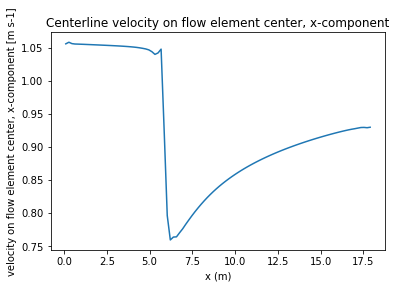

In [5]:
cline_variable = interp.griddata(var_data_df[['x','y','z']], 
                     var_data_df[variable],
                     cline_points[['x','y','z']])

Type='Centerline'
plt.plot(x, cline_variable)
plt.xlabel('x (m)')
plt.ylabel(f'{data.variables[variable].long_name} [{data.variables[variable].units}]')
plt.title(f'{Type} {data.variables[variable].long_name}')

## Plotting a Contour Plot for a Given Layer 

Sometimes it will be useful to plot only the raw data. Using `get_layer_data` a single layer of raw data will be retrieved from the NetCDF object. The NetCDF object, `data`, to retrieve the data from, the variable is set to 'ucx' the velocity in the x direction, and the layer of data to plot are the user inputs. Since there are 5 total layers in this example layer 2 is the middle layer and the one we will plot in this example. The `get_layer_data` outputs the length, x_layer, and width, y_layer, coordinates and the value of the specified variable in this case velocity in the x direction, 'ucx.' 


To plot the data the maximum and minimum, "max_plot_v" and "min_plot_v", values are defined to limit bounds of the color bar to show the value of the specified variable, in this case it's velocity in the x direction. The type of plot is also defined as in this case 'contour' to add to the title of the plot.

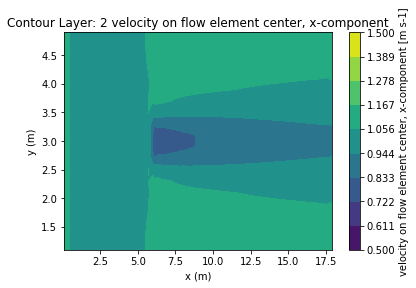

In [6]:
variable= 'ucx'
layer= 2
[x_layer,y_layer,value_layer] = d3d.get_layer_data(data, variable, layer)

max_plot_v= 1.5
min_plot_v=.5
  
Type= 'Contour'
plt.figure()
contour_plot = plt.tricontourf(x_layer,y_layer,value_layer, vmin=min_plot_v,vmax=max_plot_v,
                               levels=np.linspace(min_plot_v,max_plot_v,10))
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title(f'{Type} Layer: {layer} {data.variables[variable].long_name}')
cbar= plt.colorbar(contour_plot)
cbar.set_label(f'{data.variables[variable].long_name} [{data.variables[variable].units}]')

## Plotting a Contour Plot layer 

If you wanted to look at a contour plot of a specific depth you can create a contour plot over given points. Expanding on the centerline plot points we can create an array along the width of the flume, `y_contour` to add to the array along the length of the flume, `x`, and the point for the depth we want to look at `z`.  `create_points` then outputs a grid of points to calculate the contour values over.

In [7]:
x = np.linspace(xmin, xmax, num=100)
y_contour = np.linspace(ymin, ymax, num=40)
z = np.mean([zmin,zmax])

contour_points = d3d.create_points(x, y_contour, z) 

Next the data is interpolated on to the points created and added to the contour_points dataframe under the variable name `contour_variable`. 

In [8]:
contour_points['contour_variable'] = interp.griddata(var_data_df[['x','y','z']], 
                                                     var_data_df[variable],
                                                     contour_points[['x','y','z']])

The results are then plotted. The minimum and maximum values show on the graph are defined by "max_plot_v" and "min_plot_v" as used in the previous example. The contour plot of the velocity is then output at the center depth of the flume. 

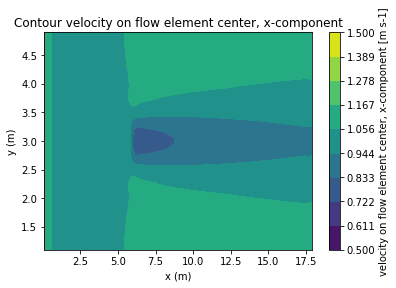

In [9]:
max_plot_v= 1.5
min_plot_v=.5

#Plot contour
Type= 'Contour'
plt.figure()
contour_plot = plt.tricontourf(contour_points.x,contour_points.y,contour_points.contour_variable,
                               vmin=min_plot_v,vmax=max_plot_v,levels=np.linspace(min_plot_v,max_plot_v,10))
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title(f'{Type} {data.variables[variable].long_name}')
cbar= plt.colorbar(contour_plot)
cbar.set_label(f'{data.variables[variable].long_name} [{data.variables[variable].units}]')



## Contour Plot of Turbulent Intensity 
Turbulent Intensity is the ratio of the magnitude of turbulent velocity to total velocity. The function `turbulent_intensity` automaticaly pulls variables 'ucx', 'ucy', 'ucz', and 'turkin1' as the velocity in the x, y, z and turbulence respetivly. The function then calculates and outputs the turbulent intensity, `TI`, for any given time_index. In this example it is calculating the turbulent intensity over the same contour_points used above, however it can also calculate over 'cells', the coordinate system for the raw velocity data, or 'faces', the coordinate system for the raw turbulence data. If nothing is specified for 'points', 'cells' is the defalt coordiante system.    

Following the same format as the previous two contour plots the limits of the maximum and minimum value are defined by user as well as a string for the type of plot. The code then outputs a contour plot of the turbulent intensity.

points provided


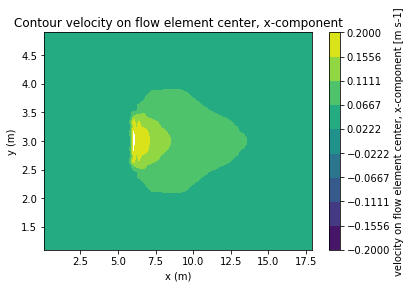

In [10]:
TI= d3d.turbulent_intensity(data, contour_points)

max_plot_v= 0.2
min_plot_v=-0.2

Type= 'Contour'
plt.figure()
contour_plot = plt.tricontourf(contour_points.x, contour_points.y, TI,
                               vmin=min_plot_v, vmax=max_plot_v,levels=np.linspace(min_plot_v,max_plot_v,10))
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title(f'{Type} {data.variables[variable].long_name}')
cbar= plt.colorbar(contour_plot)
cbar.set_label(f'{data.variables[variable].long_name} [{data.variables[variable].units}]')

## Grid data 
Similar to the `turbulent_intensity` function shown above the `grid data` function is used to interpolate data sets on the same grid. Unlike the `turbulent_intensity` function this function lets you input the variable names that you want to calculate points for. For this example, we input the variable names, 'ucx' and 'turkin1', the NetCDF object, 'data', and the points to interpolate over 'faces'. The output is an array, ` Var`, with the interpolated data. The data can be called as shown with ‘Var.’ followed by the variable name.   

In [16]:
variables= ['ucx', 'turkin1']

Var= d3d.grid_data(data, variables, points= 'faces')

Var.ucx, Var.turkin1

(0       0.719636
 1       0.694261
 2       0.719636
 3       0.700325
 4       0.694261
           ...   
 8995    1.234666
 8996    1.214983
 8997    1.251318
 8998    1.234800
 8999    1.251418
 Name: ucx, Length: 9000, dtype: float64,
 0       0.011769
 1       0.012186
 2       0.012374
 3       0.012030
 4       0.012186
           ...   
 8995    0.001459
 8996    0.001035
 8997    0.001467
 8998    0.001246
 8999    0.001297
 Name: turkin1, Length: 9000, dtype: float64)